# Evaluate Models

This Notebook access the saved model files see how the models are learning


In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import platform
import gym
import pickle as pickle
import pympler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical
import gc

# For advanced computer vision
import cv2

# For memory tracking
from pympler import summary
from pympler import muppy

cpu_dtype = torch.FloatTensor
gpu_dtype = torch.cuda.FloatTensor

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())

Python version:  3.6.4


## What the REINFORCE-Karpathy NN is learning

We display 20 of the W1 matrix columns which is elementwise multiplied against an image vector.

W1 is essentially doing pattern matching on:

1. The trajecory of the puck
2. Position of the 2 paddles

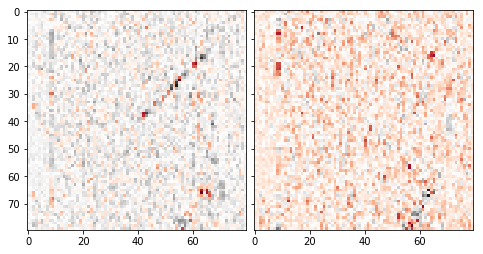

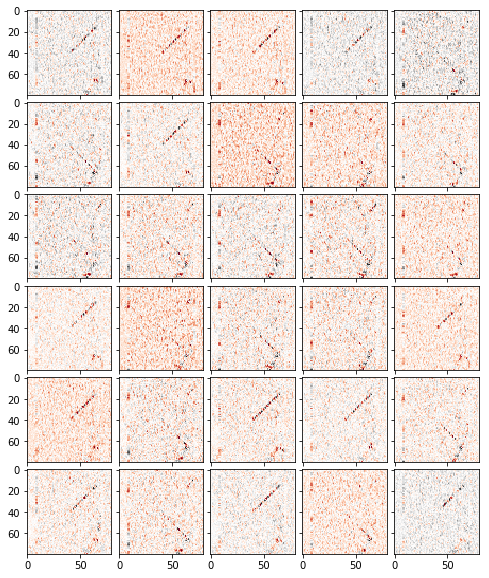

In [13]:
model = pickle.load(open('./results/pg-numpy/save (numpy-lr-1e-3-10000ep).p', 'rb'))

fig = plt.figure(1, (8., 5.))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.1)  # pad between axes in inch. 

# The AxesGrid object work as a list of axes.
image = model['W1'][0,:].reshape(80,80)
grid[0].imshow(image, cmap='RdGy')
image = model['W1'][8,:].reshape(80,80)
grid[1].imshow(image, cmap='RdGy')

plt.show()


fig = plt.figure(1, (12., 10.))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 5), axes_pad=0.1)  # pad between axes in inch. 

for i in range(30):
    # The AxesGrid object work as a list of axes.
    image = model['W1'][i,:].reshape(80,80)
    grid[i].imshow(image, cmap='RdGy')

plt.show()

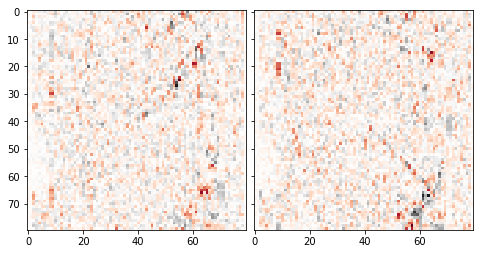

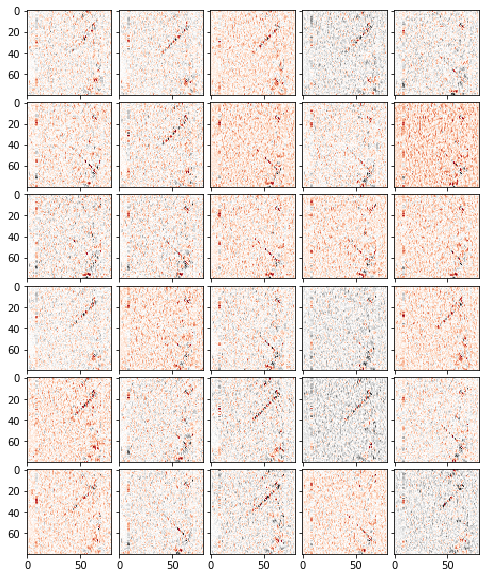

In [14]:
model = pickle.load(open('./results/pg-numpy/save (numpy-lr-1e-3-30000ep).p', 'rb'))

fig = plt.figure(1, (8., 5.))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.1)  # pad between axes in inch. 

# The AxesGrid object work as a list of axes.
image = model['W1'][0,:].reshape(80,80)
grid[0].imshow(image, cmap='RdGy')
image = model['W1'][8,:].reshape(80,80)
grid[1].imshow(image, cmap='RdGy')

plt.show()


fig = plt.figure(1, (12., 10.))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 5), axes_pad=0.1)  # pad between axes in inch. 

for i in range(30):
    # The AxesGrid object work as a list of axes.
    image = model['W1'][i,:].reshape(80,80)
    grid[i].imshow(image, cmap='RdGy')

plt.show()

## REINFORCE-V2 is worse than REINFORCE-Karpathy


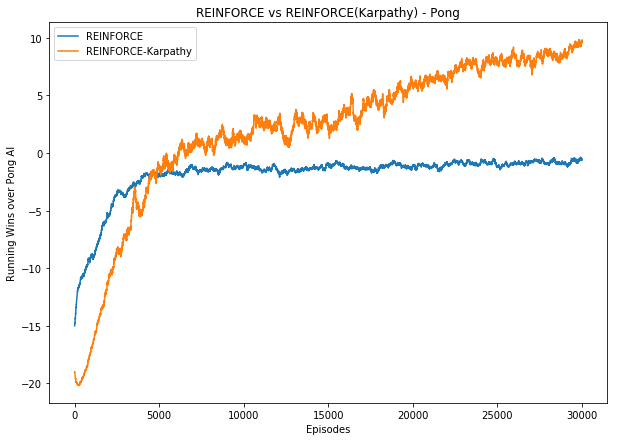

In [7]:
data1 = pickle.load(open('./results/reinforce/reinforce-v2/pong_ep=30000history.p', 'rb'))
data2 = pickle.load(open('./results/pg-numpy/reward_history-pg-numpy-30000ep-lr-1e-3.p', 'rb'))

# Plot out reward and running reward over training episodes
plt.figure(figsize=(10, 7))


plt.plot(list(range(1,len(data1)+1)), np.array(data1)[:,1], label='REINFORCE')
plt.plot(list(range(1,len(data2)+1)), np.array(data2)[:,1], label='REINFORCE-Karpathy')
plt.title('REINFORCE vs REINFORCE(Karpathy) - Pong')
plt.xlabel('Episodes')
plt.ylabel('Running Wins over Pong AI')
plt.legend()
plt.show()


## What the REINFORCE-V2 NN is learning

We display 20 of the affine1.weight matrix columns which is elementwise multiplied against an image vector.

It does a very poor job of learning the two things which Karpathy's numpy code has mastered.

1. The trajecory of the puck
2. Position of the 2 paddles

The update rule used is ADAM vs. RMSProp for REINFORCE-Karpathy.

In [15]:
# The function approximator of the Policy is a 2 layer NN. 
# - The policy takes in the state of Pong, which is a resampled 40x40 image
# - The action is the softmax output (Left or Right)
# - there are 200 hidden units in the NN
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(1600, 200)
        self.affine2 = nn.Linear(200, 2)  
        
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)

    
model = Policy()
file_name='./results/reinforce/reinforce-v2/pong_ep=28000model.pt'
model.load_state_dict(torch.load(file_name))


(200, 1600)


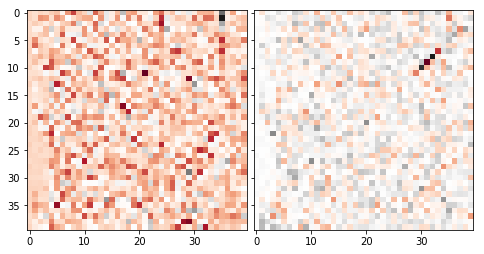

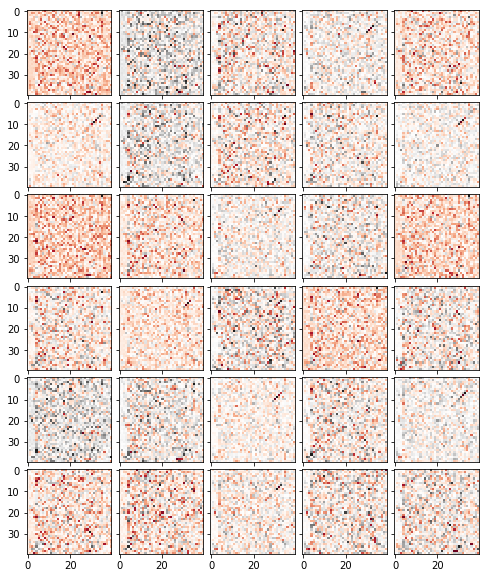

In [16]:
from mpl_toolkits.axes_grid1 import ImageGrid

W = {}

for name, param in model.named_parameters():
    W[name]=param.data.numpy()
    
print (W['affine1.weight'].shape)



# model = pickle.load(open('./results/pg-numpy/save (numpy-lr-1e-3-30000ep).p', 'rb'))

fig = plt.figure(1, (8., 5.))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.1)  # pad between axes in inch. 

# The AxesGrid object work as a list of axes.
image = W['affine1.weight'][0,:].reshape(40,40)
grid[0].imshow(image, cmap='RdGy')
image = W['affine1.weight'][9,:].reshape(40,40)
grid[1].imshow(image, cmap='RdGy')

plt.show()


fig = plt.figure(1, (12., 10.))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 5), axes_pad=0.1)  # pad between axes in inch. 

for i in range(30):
    # The AxesGrid object work as a list of axes.
    image = W['affine1.weight'][i,:].reshape(40,40)
    grid[i].imshow(image, cmap='RdGy')

plt.show()

## What the REINFORCE-V3 NN is learning

REINFORCE-V3: Change update rule to RMSProp (weight_decay=0)

We display 50 of the affine1.weight matrix columns which is elementwise multiplied against an image vector.We are seeing clear puck trajectories in the weights of REINFORCE-V3. 

Differences between the weights:
1. By the 30000th episodes, REINFORCE-Karpathy is learning about the agent's puck position
2. REINFORCE-V3's weights resemble those of REINFORCE-Karpathy's 10000th episodes, where it is learning only the puck trajectories, but not the agent's paddle location relative to the trajectory.

In a nutshell, REINFORCE-V3's NN stops learning from episode 10000 onward.

(200, 6400)


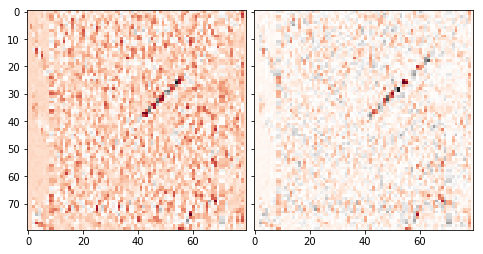

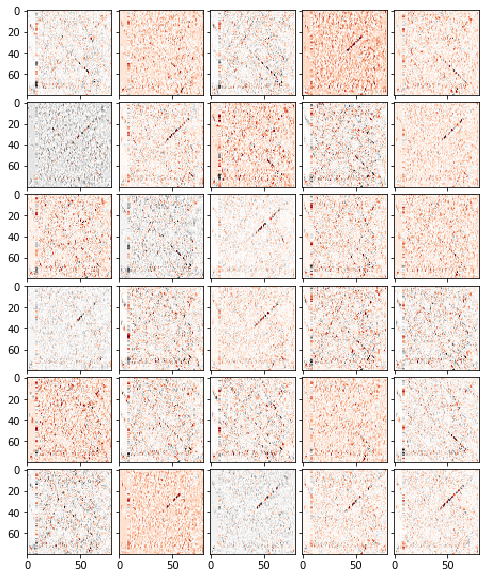

In [18]:
from mpl_toolkits.axes_grid1 import ImageGrid

# The function approximator of the Policy is a 2 layer NN. 
# - The policy takes in the state of Pong, which is a resampled 40x40 image
# - The action is the softmax output (Left or Right)
# - there are 200 hidden units in the NN
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(6400, 200)
        self.affine2 = nn.Linear(200, 2)  
        
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)

    
model = Policy()
file_name='./results/reinforce/reinforce-v3/pong_ep=30000model.pt'
model.load_state_dict(torch.load(file_name))

W = {}

for name, param in model.named_parameters():
    W[name]=param.data.numpy()
    
print (W['affine1.weight'].shape)



# model = pickle.load(open('./results/pg-numpy/save (numpy-lr-1e-3-30000ep).p', 'rb'))

fig = plt.figure(1, (8., 5.))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.1)  # pad between axes in inch. 

# The AxesGrid object work as a list of axes.
image = W['affine1.weight'][3,:].reshape(80,80)
grid[0].imshow(image, cmap='RdGy')
image = W['affine1.weight'][17,:].reshape(80,80)
grid[1].imshow(image, cmap='RdGy')

plt.show()


fig = plt.figure(1, (12., 10.))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 5), axes_pad=0.1)  # pad between axes in inch. 

for i in range(30):
    # The AxesGrid object work as a list of axes.
    image = W['affine1.weight'][i,:].reshape(80,80)
    grid[i].imshow(image, cmap='RdGy')

plt.show()

## Load Parameters and Let's Play

The code below loads parameters from saved model into the REINFORCE agent and renders 1 episode. The agent and the game will now play til one of them reach 21 points.

In [4]:
import argparse
import gym
import numpy as np
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical
import gc

gamma=0.99
seed=543
render=False
log_interval=10
batch_size = 1000  # Debug Underperformance - (2) change batch_sise
verbose=False  # To step through the code and understand what is going on


# The function approximator of the Policy is a 2 layer NN. 
# - The policy takes in the state of Pong, which is a resampled 40x40 image
# - The action is the softmax output (Left or Right)
# - there are 200 hidden units in the NN
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(6400, 200)
        self.affine2 = nn.Linear(200, 2)  
        
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)

# Debug Underperformance - (1) Change downsampling
def prepro80(I):
    """ 
    prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector 
    """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()


def select_action(state):
    """ 
    Use Policy to select an action based on state returned by Pong. The output expected by the PONG 
    is:
    ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
    
    So we need to return 2 (UP/RIGHT) and 3(DOWN/LEFT)
    """
    
    state = torch.from_numpy(state).float().unsqueeze(0)
    if verbose:
        print ("Pong's state output:", state.shape, state)
    
    # Use Policy to generate probability for action
    probs = model(Variable(state.type(gpu_dtype), requires_grad=False))

    # Sample action stochastically    
    m = Categorical(probs)
    action = m.sample()
    if verbose:
        print ("Pong Action:", action.data[0]+2)
        print ("log_prob(action):", m.log_prob(action))
        
    # Store log_prob (score function) into a list for calculating policy gradient    
    model.saved_log_probs.append(m.log_prob(action))
    
    del state, probs, m
    
    return action.data[0]+2  # UP=2, DOWN=3


# Call an instance of the Policy and load it with a parameter file
model = Policy().cuda()
# file_name='./results/actor-critic/pong_ep=18000model.pt'
file_name='./results/reinforce/reinforce-v3/pong_ep=30000model.pt'
model.load_state_dict(torch.load(file_name))
model.eval() # Put the model in test mode (the opposite of model.train(), essentially)    

env = gym.make("Pong-v0")
state = env.reset()
prev_x = None # used in computing the difference frame

reward_sum = 0

t = 0

while t < 10000:  # make sure there is no infinite loop
  t += 1
  env.render()
    
  time.sleep(0.01)  # slow it down for us to observe

  # preprocess the observation, set input to network to be difference image
  cur_x = prepro80(state)
  state = cur_x - prev_x if prev_x is not None else np.zeros(6400)
  prev_x = cur_x

  # Sample an action from Policy based on state provided by env
  action = select_action(state)
        
  # step env through the sampled action
  state, reward, done, _ = env.step(action)
  reward_sum += reward
        
  if done: # an episode finished
    gc.collect()  # clean up some garbage
    torch.cuda.empty_cache()  # Release GPU memory
    break

env.close()
print (reward_sum)

-10.0


## REINFORCE-V4a

We are intrigued by the difference in weight images when we switch update rule from ADAM to RmsProp. We decide to try a few difference update rules and learning rates.

This is what RmsProp-lr=1e-3 learn by ep=2000:

1. positions of the paddles
2. puck trajectories

In V4a, we incorrectly set weight_decay to 0.99

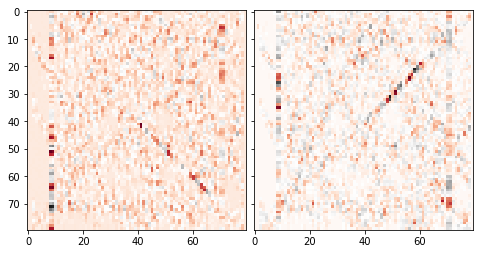

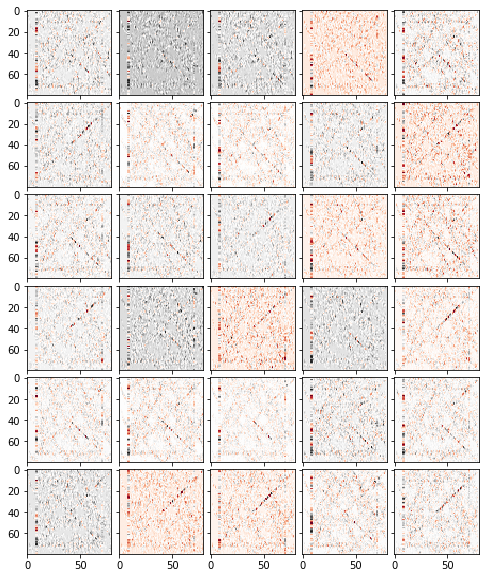

In [6]:
from mpl_toolkits.axes_grid1 import ImageGrid

# The function approximator of the Policy is a 2 layer NN. 
# - The policy takes in the state of Pong, which is a resampled 40x40 image
# - The action is the softmax output (Left or Right)
# - there are 200 hidden units in the NN
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(6400, 200)
        self.affine2 = nn.Linear(200, 2)  
        
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)
    
model = Policy()
file_name='./results/reinforce/reinforce-v4/pong_RmsProp-lr=1e-3ep=2000model.pt'
model.load_state_dict(torch.load(file_name))

W = {}

for name, param in model.named_parameters():
    W[name]=param.data.numpy()

# model = pickle.load(open('./results/pg-numpy/save (numpy-lr-1e-3-30000ep).p', 'rb'))

fig = plt.figure(1, (8., 5.))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.1)  # pad between axes in inch. 

# The AxesGrid object work as a list of axes.
image = W['affine1.weight'][3,:].reshape(80,80)
grid[0].imshow(image, cmap='RdGy')
image = W['affine1.weight'][19,:].reshape(80,80)
grid[1].imshow(image, cmap='RdGy')

plt.show()

fig = plt.figure(1, (12., 10.))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 5), axes_pad=0.1)  # pad between axes in inch. 

for i in range(30):
    # The AxesGrid object work as a list of axes.
    image = W['affine1.weight'][i,:].reshape(80,80)
    grid[i].imshow(image, cmap='RdGy')

plt.show()

In [ ]:
## REINFORCE-V4b

We are intrigued by the difference in weight images when we switch update rule from ADAM to RmsProp. We decide to try a few difference update rules and learning rates.

This is what RmsProp-lr=1e-3 learn by ep=2000:

1. positions of the paddles
2. puck trajectories

In V4a, we incorrectly set weight_decay to 0.99

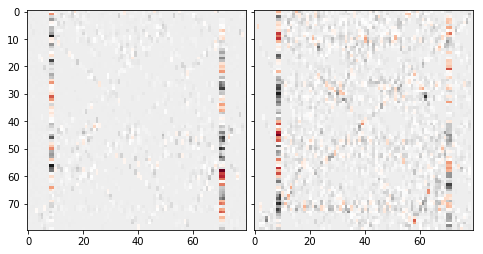

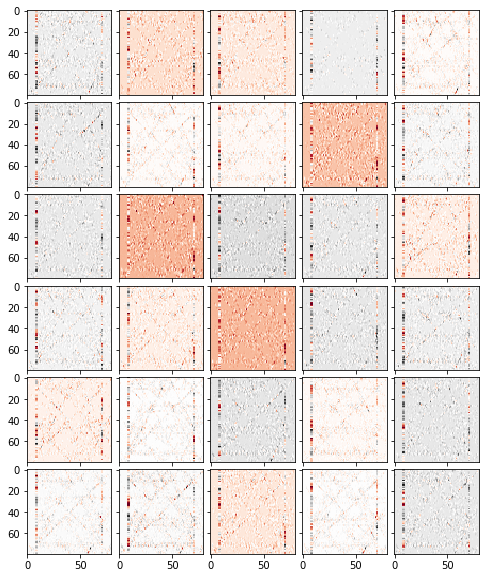

In [7]:
from mpl_toolkits.axes_grid1 import ImageGrid

# The function approximator of the Policy is a 2 layer NN. 
# - The policy takes in the state of Pong, which is a resampled 40x40 image
# - The action is the softmax output (Left or Right)
# - there are 200 hidden units in the NN
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(6400, 200)
        self.affine2 = nn.Linear(200, 2)  
        
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)

model = Policy()
file_name='./results/reinforce/pong_ep=20000model.pt'
model.load_state_dict(torch.load(file_name))

W = {}

for name, param in model.named_parameters():
    W[name]=param.data.numpy()

# model = pickle.load(open('./results/pg-numpy/save (numpy-lr-1e-3-30000ep).p', 'rb'))

fig = plt.figure(1, (8., 5.))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.1)  # pad between axes in inch. 

# The AxesGrid object work as a list of axes.
image = W['affine1.weight'][3,:].reshape(80,80)
grid[0].imshow(image, cmap='RdGy')
image = W['affine1.weight'][19,:].reshape(80,80)
grid[1].imshow(image, cmap='RdGy')

plt.show()

fig = plt.figure(1, (12., 10.))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 5), axes_pad=0.1)  # pad between axes in inch. 

for i in range(30):
    # The AxesGrid object work as a list of axes.
    image = W['affine1.weight'][i,:].reshape(80,80)
    grid[i].imshow(image, cmap='RdGy')

plt.show()

## Misc

In [19]:
w1=np.random.randn(200,6400)
print (w1.shape)

x=np.random.randn(6400,1)
print (x.shape)

h = np.dot(w1,x)
print (h.shape)


w2=np.random.randn(1,200)
print (w2.shape)


logp = np.dot(w2,h)
print (logp)

(200, 6400)
(6400, 1)
(200, 1)
(1, 200)
[[-337.69488641]]


In [33]:
from torch.distributions import Categorical

m = Categorical(torch.Tensor([ 0.25, 0.25, 0.25, 0.25 ]))

action = m.sample()

print (action)

print (m.log_prob(action))


 0
[torch.LongTensor of size 1]


-1.3863
[torch.FloatTensor of size 1]

